In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Palette
sns.set_palette("icefire")

# Load and Overview


In [2]:
train = pd.read_csv("data/train.csv", index_col=0)
test = pd.read_csv("data/test.csv", index_col=0)
# orig = pd.read_csv("/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv")

print(
    "Missing Train: ",
    train.isnull().sum().sum(),
    " - Missing Test: ",
    test.isnull().sum().sum(),
    end="\n\n",
)
train.head(3)

Missing Train:  0  - Missing Test:  0



,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0


In [3]:
train.describe(include="all")

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994,593994,593994,593994,593994,593994,593994.000000
unique,NaN,NaN,NaN,NaN,NaN,3,4,5,5,8,30,NaN
top,NaN,NaN,NaN,NaN,NaN,Female,Single,Bachelor's,Employed,Debt consolidation,C3,NaN
freq,NaN,NaN,NaN,NaN,NaN,306175,288843,279606,450645,324695,58695,NaN
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345,NaN,NaN,NaN,NaN,NaN,NaN,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,2.008959,NaN,NaN,NaN,NaN,NaN,NaN,0.400883
min,6002.430000,0.011000,395.000000,500.090000,3.200000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


# Distribution

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 58.9+ MB


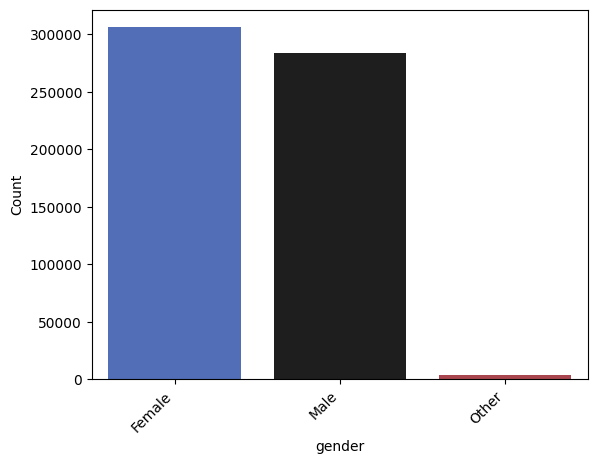

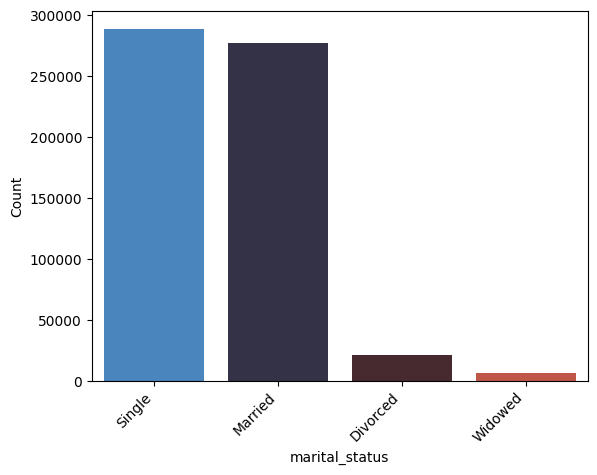

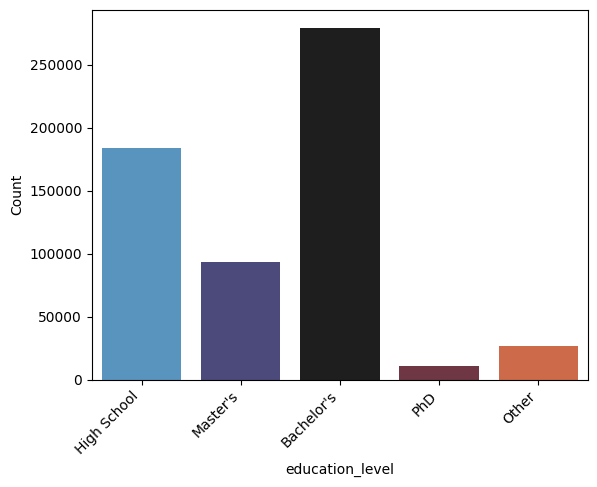

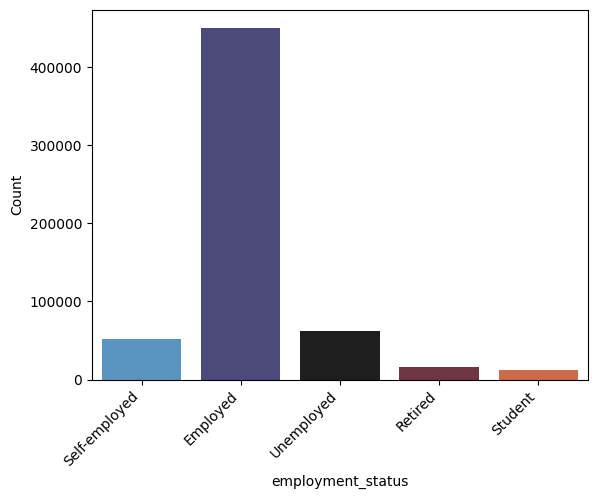

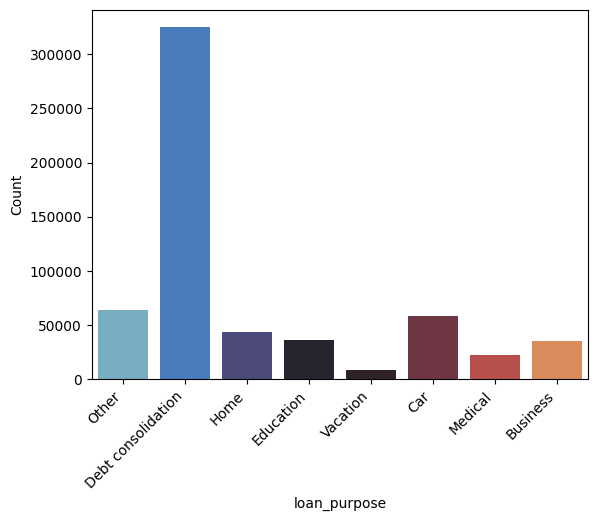

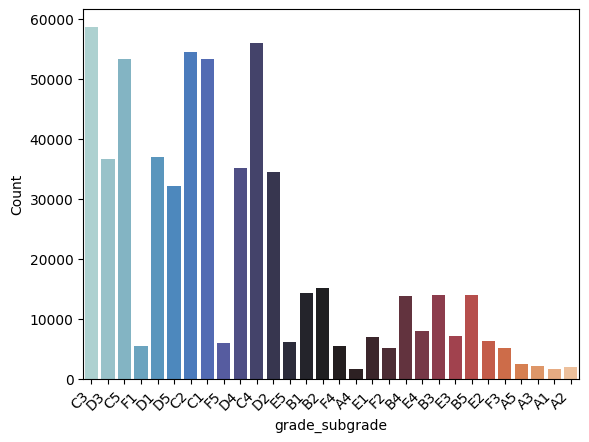

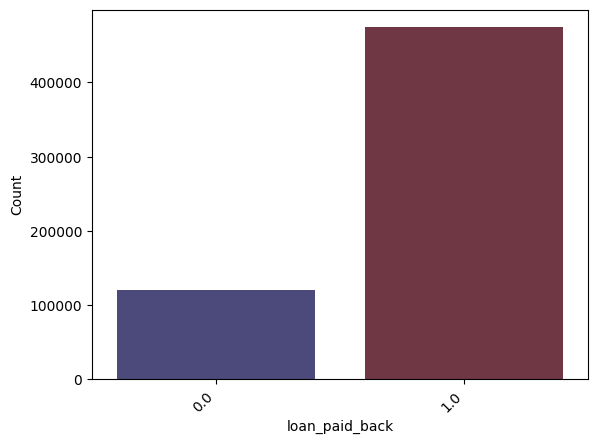

In [5]:
for col in train.select_dtypes(include="object").columns.to_list() + ["loan_paid_back"]:
    sns.countplot(data=train, x=train[col], palette="icefire")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [38]:
class Features(BaseEstimator, TransformerMixin):
    def __init__(self):
        self

    def fit(self, df, y=None):
        df = df.copy()

        return self

    def transform(self, df):
        # Ensure DataFrame input
        if not isinstance(df, pd.DataFrame):
            X = pd.DataFrame(df)
        df = df.copy()

        for col in train.select_dtypes(include="object").columns:
            df[col] = df[col].astype("category")

        return df

In [7]:
X = train.iloc[:, :-1]
y = train.iloc[:, -1]
X_pred = test

catFeatures = (
    Features().fit_transform(X, y).select_dtypes(include="category").columns.to_list()
)
catFeatures

['gender',
 'marital_status',
 'education_level',
 'employment_status',
 'loan_purpose',
 'grade_subgrade']

In [33]:
CategoryLine = Pipeline(
    [("Ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]
).set_output(transform="pandas")

InterLine = Pipeline([("Scaler", MinMaxScaler())]).set_output(transform="pandas")

Transformer = ColumnTransformer(
    [
        ("cat", CategoryLine, make_column_selector(dtype_include="category")),
        ("int", InterLine, make_column_selector(dtype_exclude="category")),
    ]
).set_output(transform="pandas")

CatTransformer = ColumnTransformer(
    [
        ("cat", CategoryLine, make_column_selector(dtype_include="category")),
    ]
).set_output(transform="pandas")

IntTransformer = ColumnTransformer(
    [
        ("int", InterLine, make_column_selector(dtype_exclude="category")),
    ]
).set_output(transform="pandas")

In [29]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

xgb = XGBClassifier(
    random_state=42,
    n_estimators=500,
    learning_rate=0.03,
    enable_categorical=True,
    verbose=False,
    device="cuda",
    n_job=-1,
)


cat = CatBoostClassifier(
    random_state=42,
    n_estimators=500,
    learning_rate=0.03,
    cat_features=catFeatures,
    verbose=False,
)

lgb = LGBMClassifier(random_state=42, n_estimators=500, learning_rate=0.03, verbose=-1)

In [43]:
xgb_all = Pipeline(
    [
        ("features", Features()),
        ("transform", Transformer),
        ("xgb", xgb),
    ]
)
xgb_int = Pipeline(
    [
        ("features", Features()),
        ("transform", IntTransformer),
        ("xgb", xgb),
    ]
)
xgb_cat = Pipeline(
    [
        ("features", Features()),
        ("transform", CatTransformer),
        ("xgb", xgb),
    ]
)

xgb_meta = Pipeline(
    [
        # ("features", Features()),
        # ("transform", Transformer),
        (
            "meta",
            StackingClassifier(
                estimators=[
                    ("xgb_all", xgb_all),
                    ("xgb_int", xgb_int),
                    ("xgb_cat", xgb_cat),
                ],
                final_estimator=xgb,
                passthrough=False,
                stack_method="predict_proba",
            ),
        ),
    ]
)

In [35]:
score_xgb_all = cross_val_score(xgb_all, X, y, cv=cv, scoring="roc_auc")
print(
    f"XGB_all scores across folds: {score_xgb_all} - Mean Score: {score_xgb_all.mean():0.4f}"
)

score_xgb_int = cross_val_score(xgb_int, X, y, cv=cv, scoring="roc_auc")
print(
    f"XGB_int scores across folds: {score_xgb_int} - Mean Score: {score_xgb_int.mean():0.4f}"
)

score_xgb_cat = cross_val_score(xgb_cat, X, y, cv=cv, scoring="roc_auc")
print(
    f"XGB_cat scores across folds: {score_xgb_cat} - Mean Score: {score_xgb_cat.mean():0.4f}",
    end="\n\n",
)

score_xgb = np.mean([score_xgb_all, score_xgb_int, score_xgb_cat], axis=0)
print(f"Overall Performance XGB: {score_xgb.mean()}")

XGB_all scores across folds: [0.92077029 0.92012637 0.91868035 0.91987005 0.91901837] - Mean Score: 0.9197
XGB_int scores across folds: [0.8035217  0.80308644 0.79986067 0.80001899 0.80110546] - Mean Score: 0.8015
XGB_cat scores across folds: [0.85774519 0.85776926 0.8569511  0.8564812  0.85985273] - Mean Score: 0.8578

Overall Performance XGB: 0.8596572104836092


In [44]:
score_meta_xgb = cross_val_score(xgb_meta, X, y, cv=cv, scoring="roc_auc")
print(
    f"XGB_all scores across folds: {score_meta_xgb} - Mean Score: {score_meta_xgb.mean():0.4f}"
)


XGB_all scores across folds: [0.92098917 0.92050563 0.9190191  0.91949315 0.91921501] - Mean Score: 0.9198


In [45]:
prediction = pd.DataFrame(data={"loan_paid_back": xgb_meta.fit(X,y).predict(X_pred)}, index=X_pred.index)
prediction.head()

,loan_paid_back
id,
593994,1.0
593995,1.0
593996,0.0
593997,1.0
593998,1.0


In [46]:
prediction.to_csv("solution/submission.csv")